## A practice of implementing QAOA in a 12-node Max Cut problem
Reference:

https://qiskit.org/textbook/ch-applications/qaoa.html

https://qiskit.org/documentation/tutorials/optimization/6_examples_max_cut_and_tsp.html

Farhi, Edward, Jeffrey Goldstone, and Sam Gutmann. "A quantum approximate optimization algorithm." arXiv preprint [arXiv:1411.4028 (2014)](https://arxiv.org/abs/1411.4028).

In [ ]:
# This code is part of Qiskit.
#
# (C) Copyright IBM 2021.
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.


In [ ]:
#Import essential packages
import matplotlib.pyplot as plt
import matplotlib.axes as axes
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

%matplotlib inline
import numpy as np
import networkx as nx

from qiskit import Aer, IBMQ
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile, assemble
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram
from qiskit.optimization.applications.ising import max_cut
from qiskit.optimization.applications.ising.common import sample_most_likely

# setup aqua logging
#import logging
#from qiskit.aqua import set_qiskit_aqua_logging
# set_qiskit_aqua_logging(logging.DEBUG)  # choose INFO, DEBUG to see the log

# Generate a random graph with $n=$12 vertices

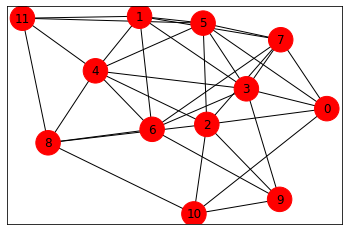

In [ ]:
# Generating a random graph with n nodes 
n = 12
V = range(n)#np.arange(0,n,1)
E=[]
edge_bool=np.random.randint(2,size=n*(n-1)) #generate a sequence of boolen numbers for all possible edges 

W=np.zeros([n,n])
idx=0
for i in range(n):
    for j in range(i):
        temp=np.random.randint(2)
        if temp==1:
            E.append((i,j,1.0))
            W[i,j]=1
            W[j,i]=1
        #if edge_bool[idx]: # if the edge_bool is 1, then add an edge between i and j vertices with a weight 1.0.
        idx+=1

G = nx.Graph()# Generate a graph
G.add_nodes_from(V) # Add the nodes
G.add_weighted_edges_from(E) # Add the edges from E

# Generate plot of the Graph
colors       = ['r' for node in G.nodes()]
pos          = nx.spring_layout(G)

def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=1, ax=default_axes, pos=pos)
    #edge_labels = nx.get_edge_attributes(G, 'weight')
    #nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

draw_graph(G, colors, pos)

#nx.draw_networkx(G, node_color=colors, node_size=600, alpha=1, ax=default_axes, pos=pos)

In [ ]:
print(W)

[[0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0.]
 [0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1.]
 [1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0.]
 [1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0.]
 [0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1.]
 [1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1.]
 [0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0.]
 [1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1.]
 [0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0.]
 [0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0.]]


## Classical Algorithms: Brutal force

The Max-cut cost function is given by:
$$C(\textbf{x}) = \sum_{i,j = 1}^n w_{ij} x_i (1-x_j).$$
where the weight $w_{ij}$ is assumed to be 1 for every edge $(i,j)\in E$ in this problem.

The solution happens when the cost function is maximized.
The brutal force method is to evaluate $C(\textbf{x})$ for all the $2^n$ combinations and get the combinations with the highest value.



Best solution = [1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0] cost = 25.0


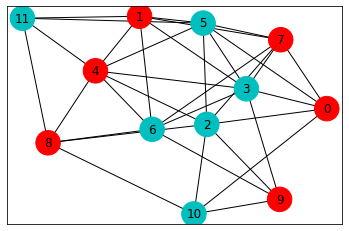

In [ ]:
best_cost_brute = 0
for b in range(2**n):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    cost = 0
    for i in range(n):
        for j in range(n):
            cost = cost + W[i,j]*x[i]*(1-x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x
    #print('case = ' + str(x)+ ' cost = ' + str(cost))

colors = ['c' if xbest_brute[i] == 0 else 'r' for i in range(n)]
draw_graph(G, colors, pos)
print('\nBest solution = ' + str(xbest_brute) + ' cost = ' + str(best_cost_brute))

This solution is just to compare for the later solution solved by QAOA. 

## Implementing QAOA



We want to find a quantum state $|\psi_p(\vec{\gamma},\vec{\beta})\rangle$, that depends on some real parameters $\vec{\gamma},\vec{\beta} \in \mathbb{R}^p$, which has the property that it maximizes the expectation value with respect to the problem Hamiltonian $H$. Given this trial state we search for parameters $\vec{\gamma}^*,\vec{\beta}^*$ that maximize $F_p(\vec{\gamma},\vec{\beta}) = \langle \psi_p(\vec{\gamma},\vec{\beta})|H|\psi_p(\vec{\gamma},\vec{\beta})\rangle$. Here we use $p=1$ as only one layer and find parameters $\beta$ and $\gamma$ that maximize $F_1$

$$ F_1(\gamma,\beta) = 3 - \left(sin^2(2\beta)sin^2(2\gamma)- \frac{1}{2}sin(4\beta)sin(4\gamma)\right)\left(1  + cos^2(4\gamma)\right).$$
This equation is obtained from the Qiskit Textbook.

In [ ]:
# Evaluate the function
step_size   = 0.001;

a_gamma         = np.arange(0, np.pi, step_size)
a_beta          = np.arange(0, np.pi, step_size)
a_gamma, a_beta = np.meshgrid(a_gamma,a_beta)

F1 = 3-(np.sin(2*a_beta)**2*np.sin(2*a_gamma)**2-0.5*np.sin(4*a_beta)*np.sin(4*a_gamma))*(1+np.cos(4*a_gamma)**2)

# Grid search for the minimizing variables
result = np.where(F1 == np.amax(F1))
a      = list(zip(result[0],result[1]))[0]

gamma  = a[0]*step_size;
beta   = a[1]*step_size;

#The smallest parameters and the expectation can be extracted
print('\n --- OPTIMAL PARAMETERS --- \n')
print('The maximal expectation value is:  M1 = %.03f' % np.amax(F1))
print('This is attained for gamma = %.03f and beta = %.03f' % (gamma,beta))



 --- OPTIMAL PARAMETERS --- 

The maximal expectation value is:  M1 = 3.432
This is attained for gamma = 1.911 and beta = 0.201


### Quantum circuit

With these parameters we can now construct the circuit that prepares the trial state for the Graph
or the Graph $G = (V,E)$ described above with vertex set $V = \{0,1,2,3,...,11,12\}$ and the randomly generated edges $E$. The circuit is going to require $n = 12$ qubits and we prepare the state 



$$ |\psi_1(\gamma ,\beta)\rangle = e^{ -i\beta B } e^{ -i\gamma H } |+\rangle^n.  $$



Recall that the terms are given by $B = \sum_{k \in V} X_k$ and $H = \sum_{(k,m) \in E} \frac{1}{2}\left(1 - Z_kZ_m\right)$. To generate the circuit we follow these steps:

 - We first implement 12 Hadamard $H$ gates to generate the uniform superposition.
 

 - This is follow by Ising type gates $U_{k,l}(\gamma)$ with angle $\gamma$ along all the edges $(k,l) \in E$. This gate can be expressed in terms of the native Qiskit gates as

  

$$ U_{k,l}(\gamma) = C_{u1}(-2\gamma)_{k,l}u1(\gamma)_k u1(\gamma)_l$$


  
 
 - Lastly we apply single qubit $X$ rotations $X_k(\beta)$ for every vertex $k \in V$ with $\beta$ as angle. This gate directly parametrized as $X_k(\beta) = R_x(2\beta)_k$ in Qiskit.
 

 - In the last step we measure the qubits in the computational basis, i.e. we perform a $Z$ measurement and record the resulting bit-string $x \in \{0,1\}^{12}$.

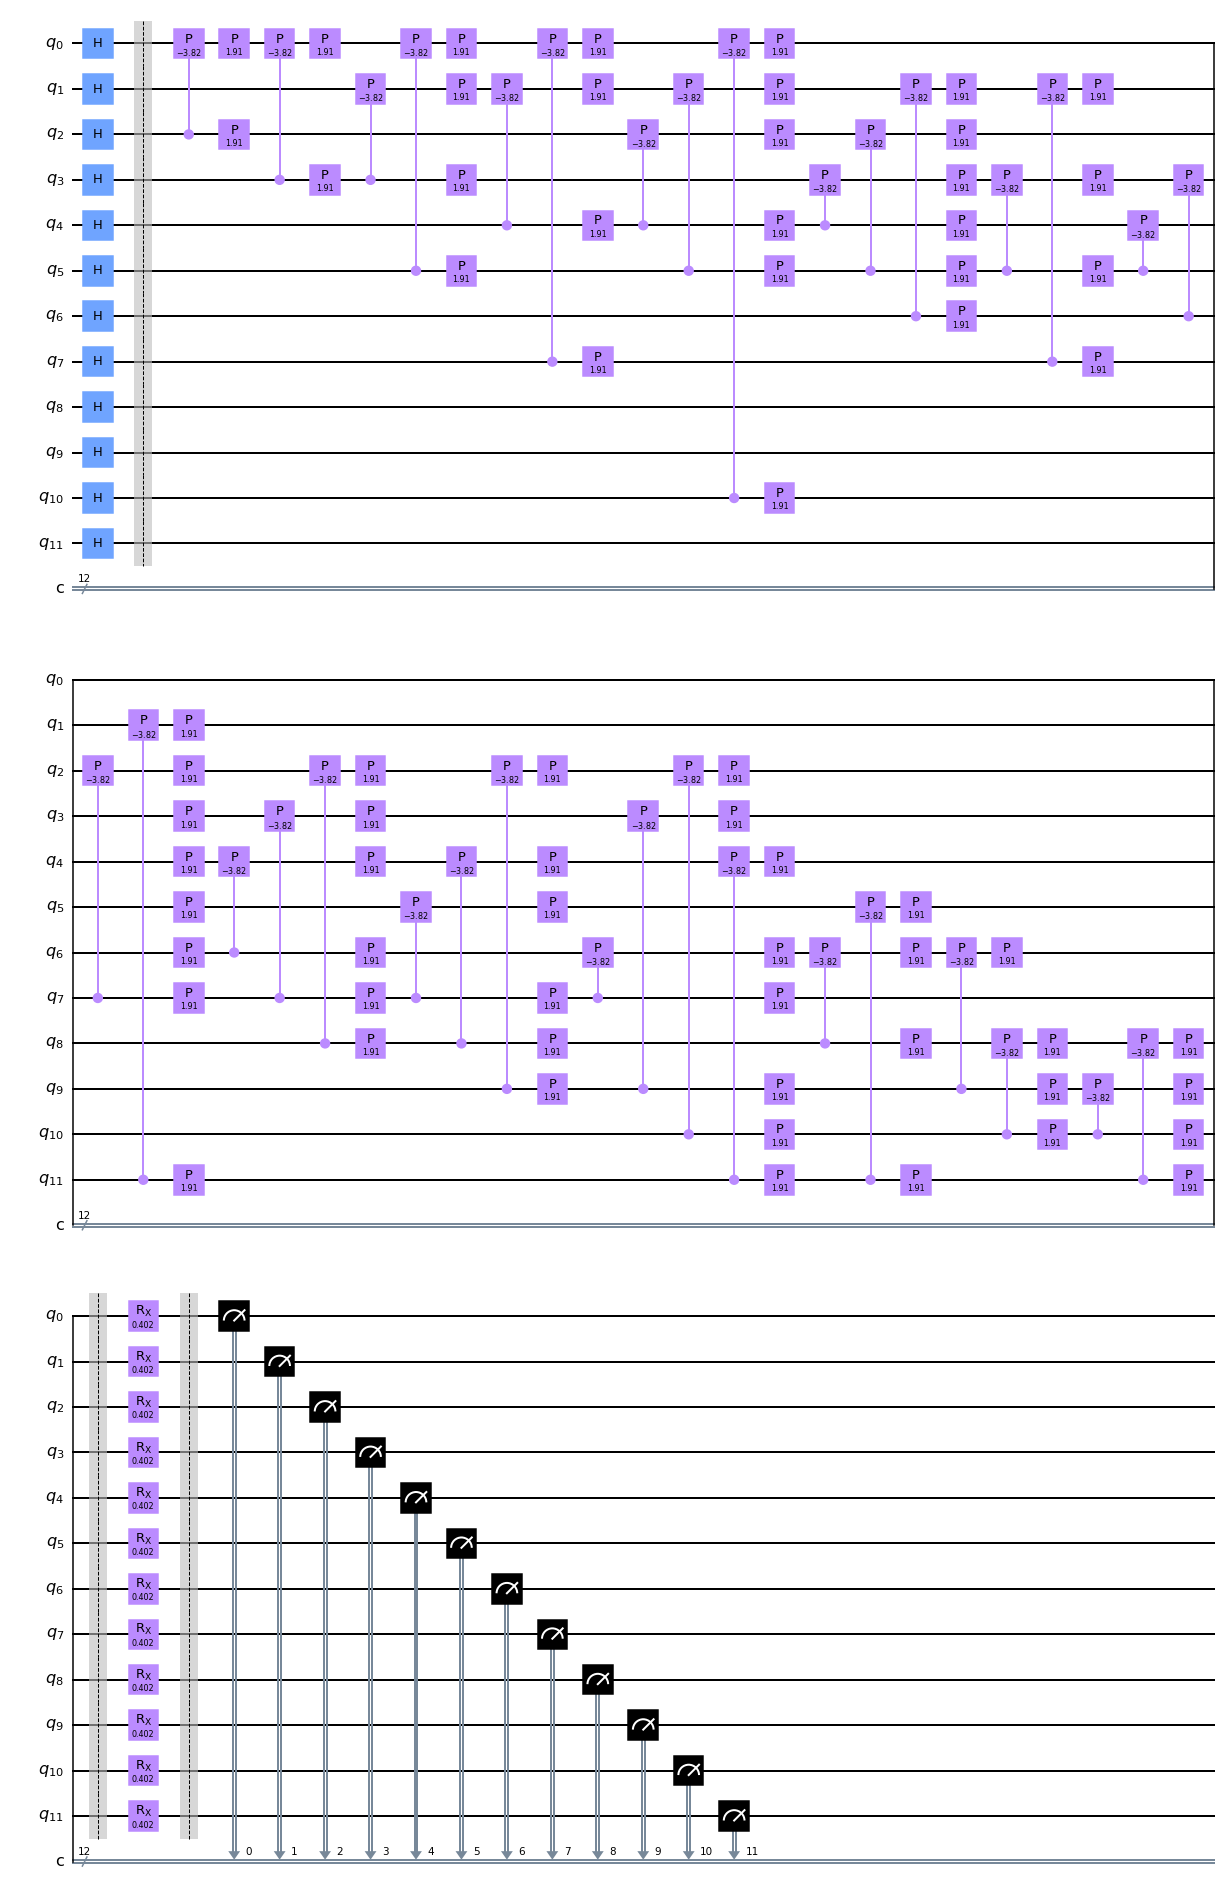

In [ ]:
# prepare the quantum and classical resisters
QAOA = QuantumCircuit(len(V), len(V))

# apply the layer of Hadamard gates to all qubits
QAOA.h(range(len(V)))
QAOA.barrier()

# apply the Ising type gates with angle gamma along the edges in E
for edge in E:
    k = edge[0]
    l = edge[1]
    QAOA.cp(-2*gamma, k, l)
    QAOA.p(gamma, k)
    QAOA.p(gamma, l)
    
# then apply the single qubit X rotations with angle beta to all qubits
QAOA.barrier()
QAOA.rx(2*beta, range(len(V)))

# Finally measure the result in the computational basis
QAOA.barrier()
QAOA.measure(range(len(V)),range(len(V)))

### draw the circuit for comparison
QAOA.draw(output='mpl')

A routine to compute the cost function value from the bit string $x$ for the given graph $G$.

In [ ]:
# Compute the value of the cost function
def cost_function_C(x,G):
    
    E = G.edges()
    if( len(x) != len(G.nodes())):
        return np.nan
        
    C = 0;
    for index in E:
        e1 = index[0]
        e2 = index[1]
        
        w=1.0
        C = C + w*x[e1]*(1-x[e2]) + w*x[e2]*(1-x[e1])
        
    return C

We first run the algorithm on a local QASM simulator.

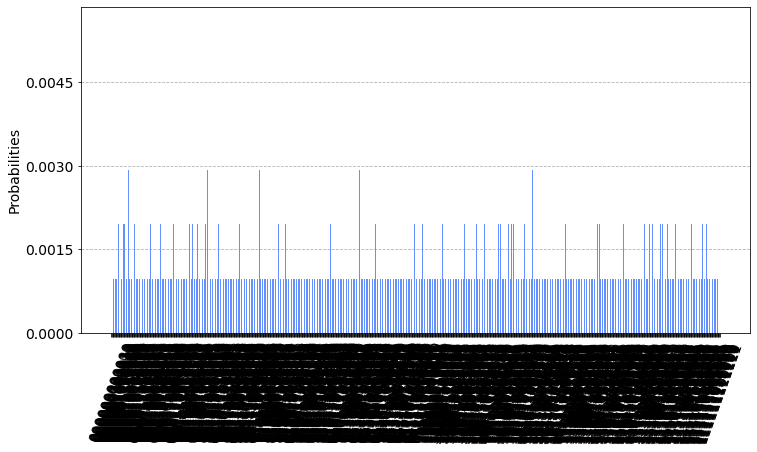

In [ ]:
# run on local simulator
backend = Aer.get_backend("qasm_simulator")
shots = 200000

TQAOA = transpile(QAOA, backend)
qobj = assemble(TQAOA)
QAOA_results = backend.run(qobj).result()

plot_histogram(QAOA_results.get_counts(),figsize = (12,6),bar_labels = False)


### Evaluate the data from the simulation.


Loop over all the resulted bitstring $x^*$ from the simulation result to sum over the average cost function. Plot the Histogram of the energies to see whether it indeed concentrates around the predicted mean. Store the result in max_C =[predicted bitstring ,C]


 --- SIMULATION RESULTS ---

The sampled mean value is M1_sampled = 0.09 while the true value is M1 = 3.43 

The approximate solution is x* = 001101100011 with C(x*) = 25 

The cost function is distributed as: 



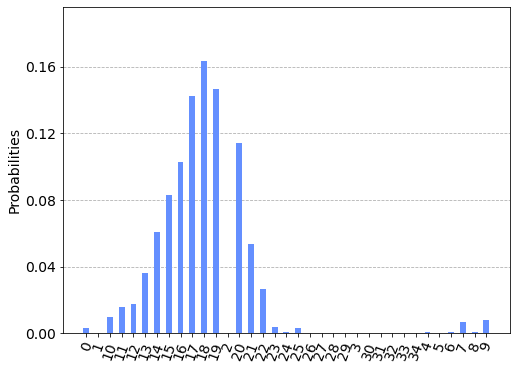

In [ ]:
# Evaluate the data from the simulator
counts = QAOA_results.get_counts()

avr_C       = 0
max_C       = [0,0]
hist        = {}

for k in range(len(G.edges())+1):
    hist[str(k)] = hist.get(str(k),0)

for sample in list(counts.keys()):

    # use sampled bit string x to compute C(x)
    x         = [int(num) for num in list(sample)]
    tmp_eng   = cost_function_C(x,G)
    
    # compute the expectation value and energy distribution
    avr_C     = avr_C    + counts[sample]*tmp_eng
    hist[str(round(tmp_eng))] = hist.get(str(round(tmp_eng)),0) + counts[sample]
    
    # save best bit string
    if( max_C[1] < tmp_eng):
        max_C[0] = sample
        max_C[1] = tmp_eng
                
M1_sampled   = avr_C/shots
""
print('\n --- SIMULATION RESULTS ---\n')
print('The sampled mean value is M1_sampled = %.02f while the true value is M1 = %.02f \n' % (M1_sampled,np.amax(F1)))
print('The approximate solution is x* = %s with C(x*) = %d \n' % (max_C[0],max_C[1]))
print('The cost function is distributed as: \n')
plot_histogram(hist,figsize = (8,6),bar_labels = False)

Plot the solution by the bitstring $x$ with the highest probability.

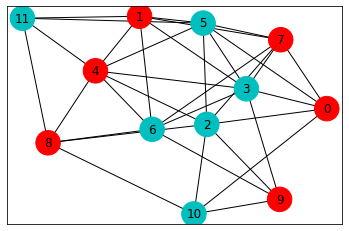

In [ ]:
colors = ['r' if max_C[0][i] == '0' else 'c' for i in range(n)]
draw_graph(G, colors, pos)

This result agree with the brutal force result. However, it predicts incorrect results below about 100000 shots.
### Tried to implement the QAOA quantum circuit on a real IBM Device.

In [ ]:
# Use the IBMQ essex device
provider = IBMQ.load_account()

In [ ]:
large_enough_devices = provider.backends(filters=lambda x: x.configuration().n_qubits >= n and
                                                   not x.configuration().simulator)
backend = least_busy(large_enough_devices)

shots = 8192

TQAOA = transpile(QAOA, backend)
qobj = assemble(TQAOA, shots=shots)
job_exp = backend.run(qobj)
job_monitor(job_exp)


<ipython-input-17-69420da2c8a3>:9: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job_exp = backend.run(qobj)


Job Status: job has successfully run


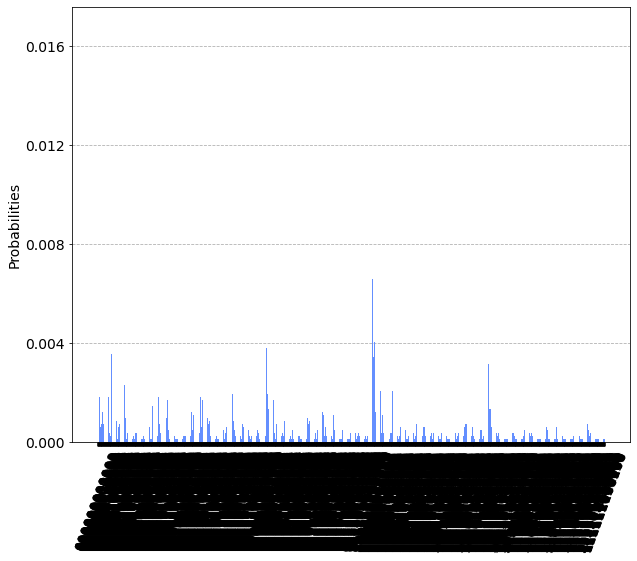

In [ ]:
exp_results = job_exp.result()
plot_histogram(exp_results.get_counts(),figsize = (10,8),bar_labels = False)



 --- EXPERIMENTAL RESULTS ---

The sampled mean value is M1_sampled = 14.48 while the true value is M1 = 3.43 

The approximate solution is x* = 110010011100 with C(x*) = 25 

The cost function is distributed as: 



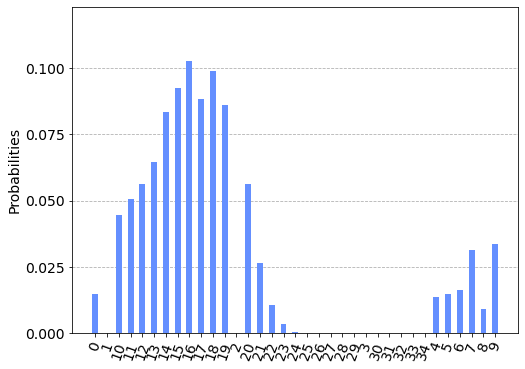

In [ ]:
# Evaluate the data from the experiment
counts_exp = exp_results.get_counts()

avr_C_exp       = 0
max_C_exp       = [0,0]
hist_exp        = {}

for k in range(len(G.edges())+1):
    hist_exp[str(k)] = hist_exp.get(str(k),0)

for sample in list(counts_exp.keys()):

    # use sampled bit string x to compute C(x)
    x         = [int(num) for num in list(sample)]
    tmp_eng   = cost_function_C(x,G)
    
    # compute the expectation value and energy distribution
    avr_C_exp     = avr_C_exp    + counts_exp[sample]*tmp_eng
    hist_exp[str(round(tmp_eng))] = hist_exp.get(str(round(tmp_eng)),0) + counts_exp[sample]
    
    # save best bit string
    if( max_C_exp[1] < tmp_eng):
        max_C_exp[0] = sample
        max_C_exp[1] = tmp_eng
                
M1_sampled_exp   = avr_C_exp/shots

print('\n --- EXPERIMENTAL RESULTS ---\n')
print('The sampled mean value is M1_sampled = %.02f while the true value is M1 = %.02f \n' % (M1_sampled_exp,np.amax(F1)))
print('The approximate solution is x* = %s with C(x*) = %d \n' % (max_C_exp[0],max_C_exp[1]))
print('The cost function is distributed as: \n')
plot_histogram(hist_exp,figsize = (8,6),bar_labels = False)


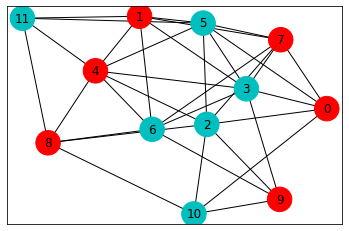

In [ ]:
colors = ['c' if max_C_exp[0][i] == '0' else 'r' for i in range(n)]
draw_graph(G, colors, pos)

The above solution is correct. However, it sometimes gives incorrect results, probably due to the limited number of shots and the noise from the real device.

### Alternative solution with the built-in QAOA in Qiskit.aqua
Below, I use the built-in QAOA in qiskit.aqua with the ADAM optimizer to solve the optimization problem.

In [ ]:
from qiskit import Aer
from qiskit.optimization.applications.ising import max_cut
from qiskit.aqua.algorithms import QAOA as QAOAlib
from qiskit.aqua.components.optimizers import ADAM
from qiskit.aqua import aqua_globals
from qiskit.aqua import QuantumInstance
from qiskit.optimization.applications.ising.common import sample_most_likely

The max_cut function directly converts the weighting matrix W into qubit operators for the Ising Hamiltonians. They can then be solved with qiskit.agua.algorithms.QAOA with a classical optimizer ADAM.

In [ ]:
qubitOp, offset = max_cut.get_operator(W)

aqua_globals.random_seed = np.random.default_rng(123)
seed = 10598
backend = Aer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

adam = ADAM(maxiter=500)
qaoa=QAOAlib(operator=qubitOp,optimizer=adam,p=1,quantum_instance=quantum_instance)
result=qaoa.run(quantum_instance)

energy: -3.054297136464748
time: 364.2530438899994
max-cut objective: -20.054297136464747
solution: [1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0.]
solution objective: 25.0


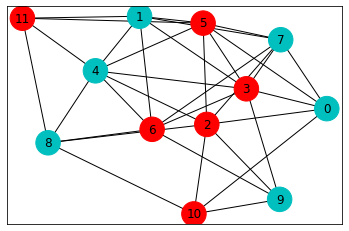

In [ ]:
# print results
x = sample_most_likely(result.eigenstate)
print('energy:', result.eigenvalue.real)
print('time:', result.optimizer_time)
print('max-cut objective:', result.eigenvalue.real + offset)
print('solution:', max_cut.get_graph_solution(x))
print('solution objective:', max_cut.max_cut_value(x, W))

# plot results
colors = ['r' if max_cut.get_graph_solution(x)[i] == 0 else 'c' for i in range(n)]
draw_graph(G, colors, pos)

It took a few minutes to run but successfully solved the problem.